In [1]:
  import sys
  sys.path.insert(0, '/content/')

In [1]:
import networkx as nx
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from itertools import combinations
from DataGenerator import DataGenerator
# Параметры по умолчанию

GAMMA_LAMBDA_0 = np.sqrt(0.5)  # θ0
WEIBULL_LAMBDA_0 = 1 / np.sqrt(10)  # υ0
def build_knn_graph(data, k):
    data = data.reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    adj = nbrs.kneighbors_graph(data).toarray()
    adj = np.minimum(adj + adj.T, 1)
    np.fill_diagonal(adj, 0)
    return nx.from_numpy_array(adj)

def build_distance_graph(data, r):
    G = nx.Graph()
    G.add_nodes_from(range(len(data)))
    for i, j in combinations(range(len(data)), 2):
        if abs(data[i] - data[j]) <= r:
            G.add_edge(i, j)
    return G

def compute_min_degree(G):
    if G.number_of_nodes() == 0:
        return 0
    return min(dict(G.degree()).values())

def compute_clique_number(G):
    if G.number_of_nodes() == 0:
        return 0
    try:
        cliques = list(nx.find_cliques(G))
        return max(len(c) for c in cliques) if cliques else 0
    except:
        return 0

# Исследование зависимости T от параметров распределений
def study_distribution_params(dgen, n=200, k=3, r=0.3, simulations=300):
    # Для Gamma (θ) и kNN
    theta_values = np.linspace(0.5, 2.5, 15)
    min_degrees = []

    for theta in theta_values:
        degrees = [compute_min_degree(build_knn_graph(dgen.generate_gamma(n, theta), k))
                   for _ in range(simulations)]
        min_degrees.append(np.median(degrees))

    plt.figure(figsize=(12,6))
    plt.plot(theta_values, min_degrees, 'b-o', linewidth=2)
    plt.xlabel('θ (Gamma)', fontsize=12)
    plt.ylabel('Медиана минимальной степени', fontsize=12)
    plt.title(f'Зависимость минимальной степени от θ\nn={n}, k={k}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Для Weibull (υ) и distance
    upsilon_values = np.linspace(0.1, 0.7, 15)
    clique_sizes = []

    for upsilon in upsilon_values:
        cliques = [compute_clique_number(build_distance_graph(dgen.generate_weibull(n, upsilon), r))
                   for _ in range(simulations)]
        clique_sizes.append(np.median(cliques))

    plt.figure(figsize=(12,6))
    plt.plot(upsilon_values, clique_sizes, 'r-o', linewidth=2)
    plt.xlabel('υ (Weibull)', fontsize=12)
    plt.ylabel('Медиана кликового числа', fontsize=12)
    plt.title(f'Зависимость кликового числа от υ\nn={n}, r={r}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

# Исследование зависимости T от параметров графа и n
def study_graph_parameters(dgen, theta0=GAMMA_LAMBDA_0, upsilon0=WEIBULL_LAMBDA_0, simulations=300):
    # Для Gamma (kNN)
    n_values = [100, 200, 400]
    k_values = np.arange(2, 15)

    plt.figure(figsize=(14, 8))

    # Создаем отдельные subplots для каждого n
    for i, n in enumerate(n_values, 1):
        plt.subplot(2, 2, i)
        medians = []
        std_devs = []

        for k in k_values:
            degrees = []
            for _ in range(simulations):
                data = dgen.generate_gamma(n, theta0)
                G = build_knn_graph(data, k)
                degrees.append(compute_min_degree(G))

            medians.append(np.median(degrees))
            std_devs.append(np.std(degrees))

        # Основной график медиан
        plt.plot(k_values, medians, 'o-', linewidth=2, label='Медиана')

        # Добавляем область стандартного отклонения
        plt.fill_between(
            k_values,
            np.array(medians) - np.array(std_devs),
            np.array(medians) + np.array(std_devs),
            alpha=0.2,
            label='±1 std'
        )

        plt.xlabel('Количество соседей k', fontsize=10)
        plt.ylabel('Минимальная степень', fontsize=10)
        plt.title(f'n={n}, θ0={theta0:.3f}', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xticks(k_values)

    # Общий заголовок
    plt.suptitle('Γ(½,θ0): Зависимость минимальной степени от k и n', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Для Weibull (distance)
    r_values = np.linspace(0.1, 0.6, 15)

    plt.figure(figsize=(12, 8))  # Увеличим размер фигуры
    for n in n_values:
        medians = []
        for r in r_values:
            cliques = []
            for _ in range(simulations):
                data = dgen.generate_weibull(n, upsilon0)
                G = build_distance_graph(data, r)
                cliques.append(compute_clique_number(G))
            medians.append(np.median(cliques))

        # Добавим маркеры и подписи значений
        plt.plot(r_values, medians, marker='o', linewidth=2, label=f'n={n}')
        for i, r_val in enumerate(r_values):
            if i % 2 == 0:  # Подписи через одну точку
                plt.text(r_val, medians[i], f"{medians[i]:.1f}",
                         fontsize=9, ha='center', va='bottom')

    plt.xlabel('Пороговое расстояние r', fontsize=12)
    plt.ylabel('Медиана кликового числа', fontsize=12)
    plt.title(f'Weibull(½,υ0): Зависимость кликового числа от r\nυ0={upsilon0:.3f}', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(0.1, 0.61, 0.05))  # Улучшенная разметка оси X
    plt.tight_layout()
    plt.show()

def study_sample_size(dgen, theta0=GAMMA_LAMBDA_0, upsilon0=WEIBULL_LAMBDA_0,
                      k=3, r=0.3, n_min=50, n_max=500, step=50, simulations=300):
    """Исследование зависимости характеристик от размера выборки"""
    n_values = range(n_min, n_max + step, step)

    # Для Gamma (kNN)
    min_degrees = []
    for n in n_values:
        degrees = []
        for _ in range(simulations):
            data = dgen.generate_gamma(n, theta0)
            G = build_knn_graph(data, k)
            degrees.append(compute_min_degree(G))
        min_degrees.append(np.median(degrees))

    plt.figure(figsize=(12, 6))
    plt.plot(n_values, min_degrees, 'b-o', linewidth=2)
    plt.xlabel('Размер выборки (n)', fontsize=12)
    plt.ylabel('Медиана минимальной степени', fontsize=12)
    plt.title(f'Γ(½,θ0): Зависимость минимальной степени от n\nθ0={theta0:.3f}, k={k}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Для Weibull (distance)
    clique_sizes = []
    for n in n_values:
        cliques = []
        for _ in range(simulations):
            data = dgen.generate_weibull(n, upsilon0)
            G = build_distance_graph(data, r)
            cliques.append(compute_clique_number(G))
        clique_sizes.append(np.median(cliques))

    plt.figure(figsize=(12, 6))
    plt.plot(n_values, clique_sizes, 'r-o', linewidth=2)
    plt.xlabel('Размер выборки (n)', fontsize=12)
    plt.ylabel('Медиана кликового числа', fontsize=12)
    plt.title(f'Weibull(½,υ0): Зависимость кликового числа от n\nυ0={upsilon0:.3f}, r={r}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()


# Построение критической области и оценка мощности
def build_critical_region(dgen, alpha=0.055, n=200, k=3, r=0.3, simulations=1000):
    # Генерация данных при H0
    T_h0_gamma = [compute_min_degree(build_knn_graph(dgen.generate_gamma(n), k))
                 for _ in range(simulations)]
    T_h0_weibull = [compute_clique_number(build_distance_graph(dgen.generate_weibull(n), r))
                   for _ in range(simulations)]

    # Критические значения
    critical_gamma = np.quantile(T_h0_gamma, 1 - alpha)
    critical_weibull = np.quantile(T_h0_weibull, 1 - alpha)

    # Оценка мощности
    power_gamma = np.mean([compute_min_degree(build_knn_graph(dgen.generate_gamma(n, 1.5), k)) >= critical_gamma
                   for _ in range(simulations)])
    power_weibull = np.mean([compute_clique_number(build_distance_graph(dgen.generate_weibull(n, 0.2), r)) >= critical_weibull
                     for _ in range(simulations)])

    print(f"Критическое значение для Gamma: {critical_gamma:.2f}, Мощность: {power_gamma:.3f}")
    print(f"Критическое значение для Weibull: {critical_weibull:.2f}, Мощность: {power_weibull:.3f}")

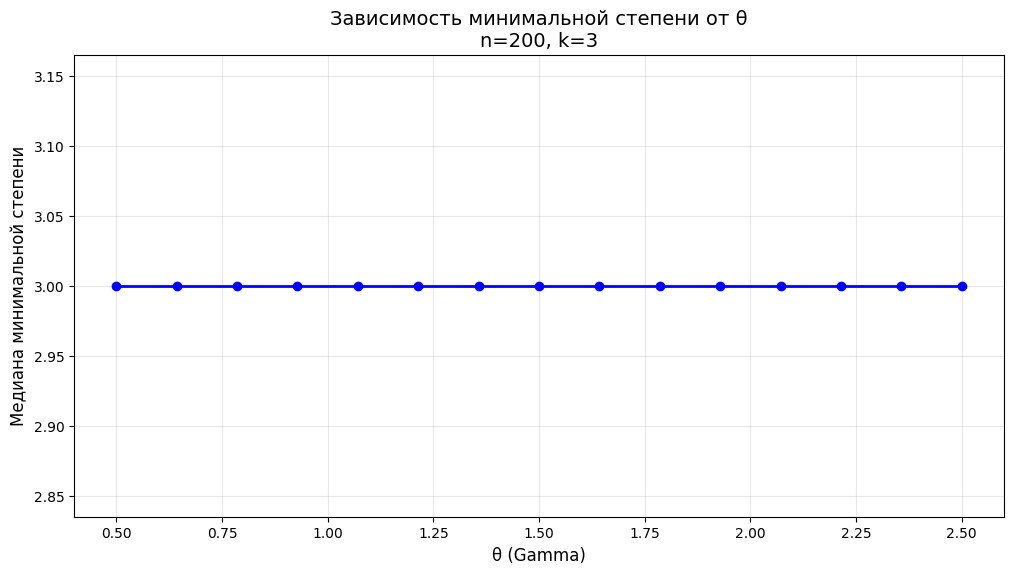

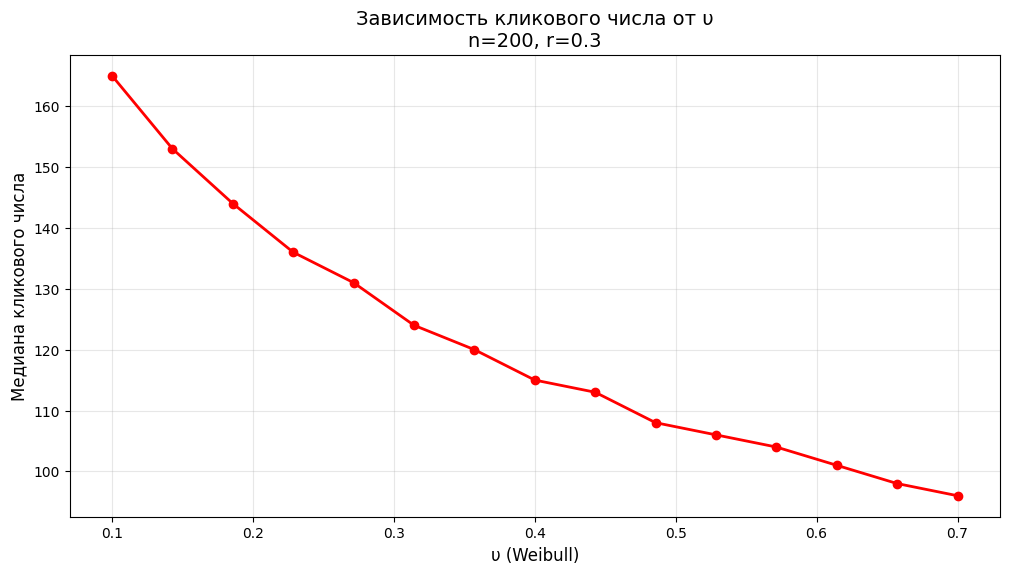

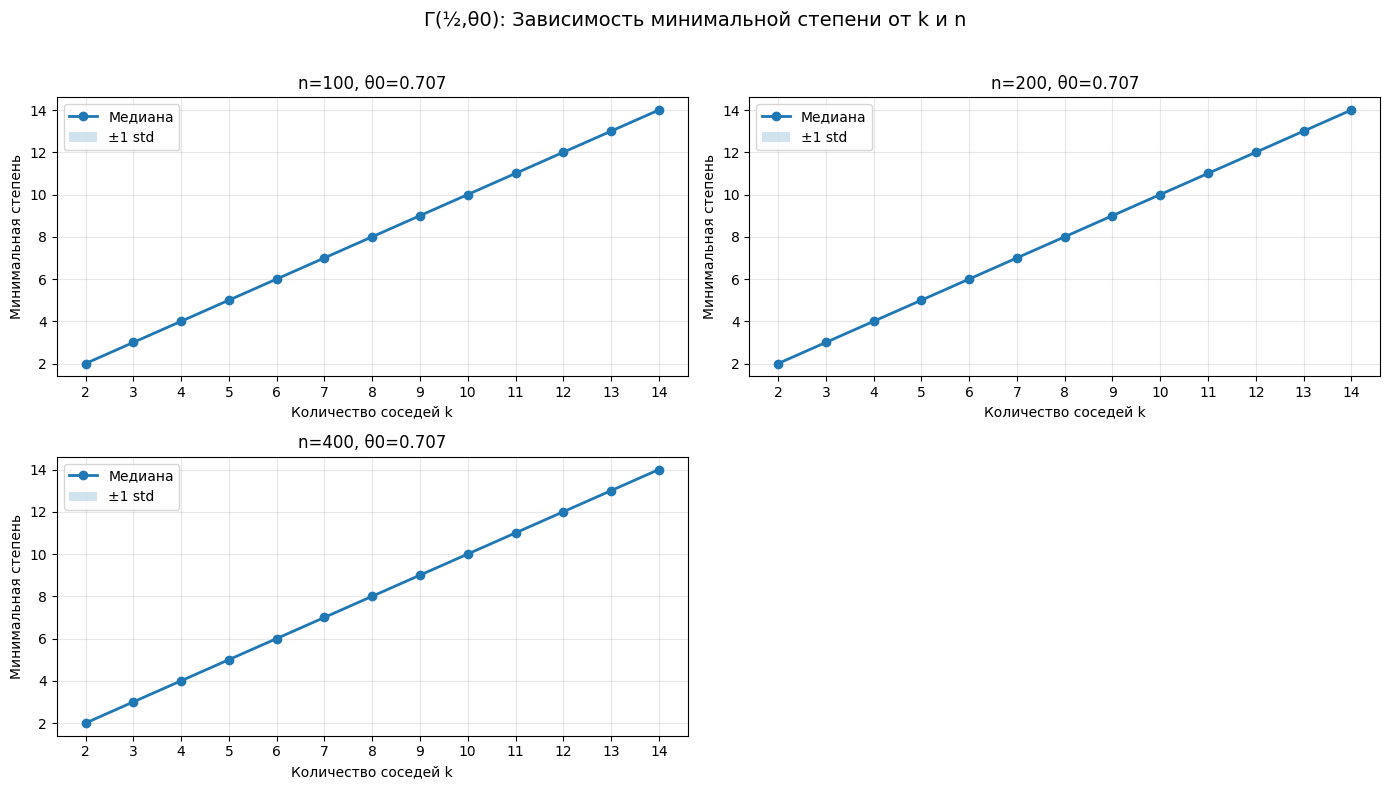

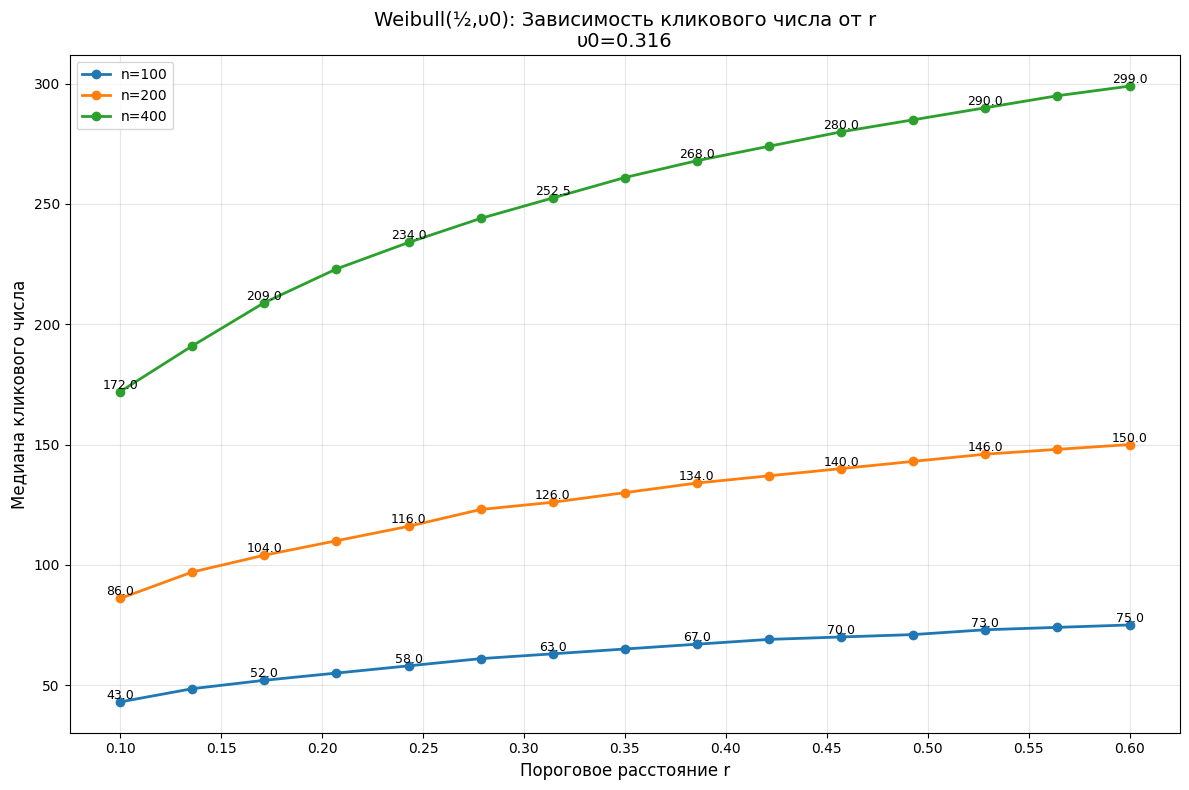


Исследование зависимости характеристик от размера выборки:


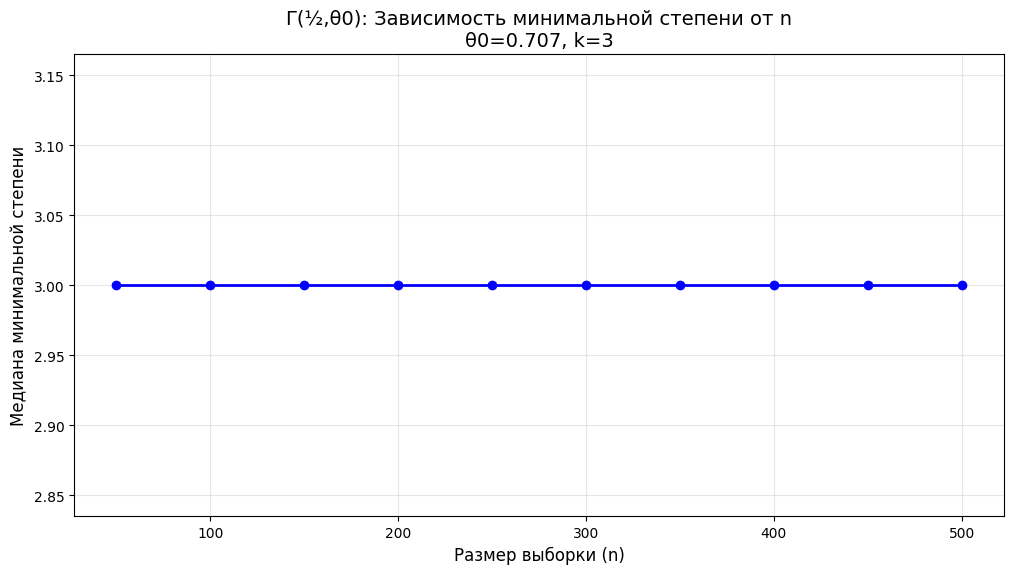

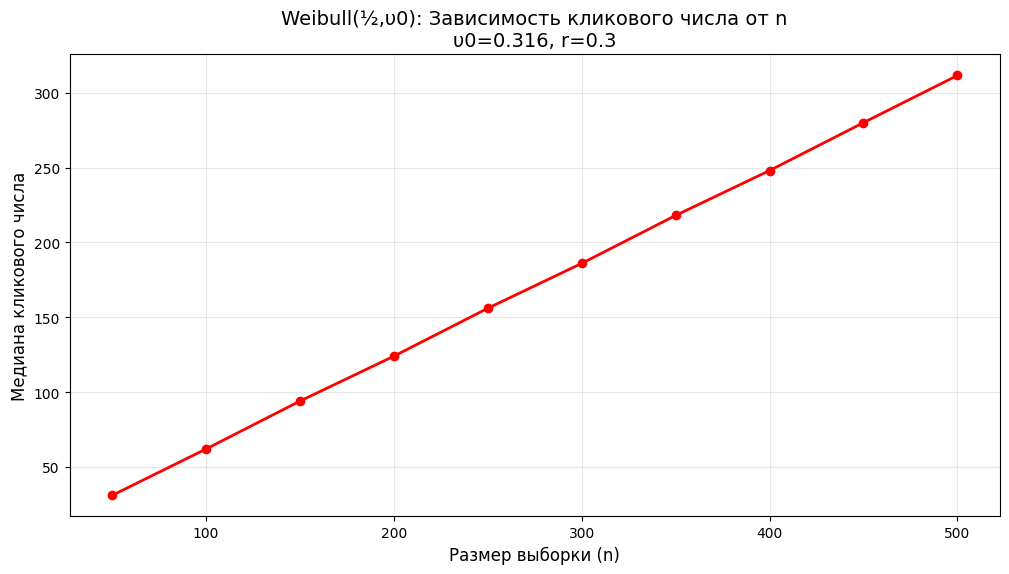


Результаты проверки гипотез:
Критическое значение для Gamma: 3.00, Мощность: 1.000
Критическое значение для Weibull: 135.00, Мощность: 0.854


In [2]:
if __name__ == "__main__":
    dgen = DataGenerator(GAMMA_LAMBDA_0, WEIBULL_LAMBDA_0)

    # Исследование зависимости от параметров распределений
    study_distribution_params(dgen)

    # Исследование зависимости от параметров графа и n
    study_graph_parameters(dgen)

    # Новое исследование: зависимость от размера выборки
    print("\nИсследование зависимости характеристик от размера выборки:")
    study_sample_size(dgen, n_min=50, n_max=500, step=50)

    # Построение критической области
    print("\nРезультаты проверки гипотез:")
    build_critical_region(dgen)